Periodontitis Detection: Proof of Concept

This notebook serves as an initial proof of concept for detecting periodontitis using image enhancement, tooth segmentation, and bone loss measurement. 

We will test the following steps on a single image:
1. Preprocessing – Apply K-CFDO image enhancement.
2. Tooth Segmentation – Train YOLOv8 segmentation model.

In [15]:
# 1. Preprocessing – Apply K-CFDO image enhancement.
''' Enhancing the X-ray images using the K-CFDO algorithm by Aldoury et al., where:
    ρ (rho) = 0.5: A regularization parameter that balances the trade-off between noise 
                   reduction and detail preservation in the image.
    k = 1.5: A scaling factor that adjusts the strength of the kernel filter, controlling 
             the emphasis on image features and smoothing effects.
    '''
import os
import shutil
import numpy as np
import cv2
from tqdm import tqdm
from scipy import special

# K-CFDO Enhancement Function
def k_cfdo_enhancement(image, rho=0.5, k=1.5):
    img = image.astype(np.float64)
    if img.max() > 1.0:
        img = img / 255.0  # Normalize
    n, m = img.shape
    enhanced_img = np.zeros_like(img)
    for i in range(n):
        for j in range(m):
            r = img[i, j]
            numerator = r ** ((1 - rho) / k)
            denominator = special.gamma(2 - rho / k)
            enhanced_img[i, j] = img[i, j] * (numerator / denominator)
    enhanced_img = (enhanced_img - enhanced_img.min()) / (enhanced_img.max() - enhanced_img.min())
    return (enhanced_img * 255).astype(np.uint8)

# Function to process images and move labels
def process_and_move_data(set_name):
    """
    Process images using K-CFDO enhancement and move corresponding labels.
    
    Parameters:
    -----------
    set_name : str
        Name of the dataset split (train, valid, or test).
    """
    # Define paths
    input_image_dir = f"../data/{set_name}/images"
    input_label_dir = f"../data/{set_name}/labels"
    
    # Define the output paths to be outside of the notebook folder
    output_image_dir = f"../enhanced_data/{set_name}/images"
    output_label_dir = f"../enhanced_data/{set_name}/labels"
    
    # Create output directories if they do not exist
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)
    
    # Process images
    for filename in tqdm(os.listdir(input_image_dir), desc=f"Processing {set_name} images"):
        if filename.endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(input_image_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # Apply enhancement
            enhanced_img = k_cfdo_enhancement(img, rho=0.5, k=1.5)
            
            # Save the enhanced image
            cv2.imwrite(os.path.join(output_image_dir, filename), enhanced_img)
            
            # Move the corresponding label file
            label_file = filename.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt')
            label_path = os.path.join(input_label_dir, label_file)
            if os.path.exists(label_path):
                shutil.copy(label_path, os.path.join(output_label_dir, label_file))

# Process each dataset split
for split in ["train", "valid", "test"]:
    process_and_move_data(split)

# Create data.yaml file for YOLOv8
data_yaml_content = f"""path: ./enhanced_data
train: train/images
val: valid/images
test: test/images

nc: 1
names: ['Individual Tooth']
"""

# Save the data.yaml file in the correct directory
yaml_path = "../enhanced_data/data.yaml"
with open(yaml_path, "w") as f:
    f.write(data_yaml_content)

print("✅ Enhancement complete! Final dataset stored in '../enhanced_data/'.")
print("✅ Labels moved successfully.")
print(f"✅ 'data.yaml' created at {yaml_path}.")


Processing test images: 100%|████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.90s/it]

✅ Enhancement complete! Final dataset stored in '../enhanced_data/'.
✅ Labels moved successfully.
✅ 'data.yaml' created at ../enhanced_data/data.yaml.


In [16]:
!pip install ultralytics

In [23]:
# 2. Tooth Segmentation – Train a YOLOv8 segmentation model.
''' 
    This script trains a YOLOv8 segmentation model to automatically segment individual teeth from dental X-ray images. 
    The model is designed for instance segmentation, which detects objects (teeth) and predicts their pixel-wise masks. 
    Using a dataset of labeled X-rays, the model learns to identify and separate each tooth.
    Key training parameters like optimizer, learning rate, and momentum are adjusted for optimal performance.

'''
from ultralytics import YOLO

# Load the YOLOv8 instance segmentation model (the segmentation model)
model = YOLO("yolov8n-seg.pt")  # Make sure you use the segmentation variant

# Train the model on the instance segmentation dataset
model.train(
    data="C:/Users/pauli/DeepDent/periodontitis/enhanced_data/data.yaml",  # Path to the data.yaml file
    epochs=50,                        # Number of epochs
    batch=8,                          # Batch size
    device="cpu",                     # Use CPU for training (or "cuda" if you have a GPU)
    
    # Optimization parameters
    optimizer="AdamW",                # Use AdamW optimizer (default is Adam)
    lr0=0.001,                        # Initial learning rate                        # Final learning rate
    momentum=0.937,                    # Momentum for the optimizer
    weight_decay=0.0005,               # Regularization term
    warmup_epochs=3,                  # Number of epochs for warmup
    warmup_momentum=0.8,              # Momentum during warmup
    warmup_bias_lr=0.1                # Bias learning rate during warmup
)

Ultralytics 8.3.99  Python-3.9.13 torch-2.6.0+cpu CPU (AMD Ryzen 5 5500U with Radeon Graphics)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=C:/Users/pauli/DeepDent/periodontitis/enhanced_data/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

train: Scanning C:\Users\pauli\DeepDent\periodontitis\enhanced_data\train\labels.cache... 35 images, 0 backgrounds, 0 c
val: Scanning C:\Users\pauli\DeepDent\periodontitis\enhanced_data\valid\labels.cache... 10 images, 0 backgrounds, 0 cor

module 'matplotlib.cm' has no attribute 'register_cmap'


optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\segment\train6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.689      4.112      3.187       1.23        169        640: 100%|██████████| 5/5 [00:36<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270     0.0673      0.748      0.297      0.101          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.603      2.899      2.262        1.1        161        640: 100%|██████████| 5/5 [00:30<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270     0.0527      0.585       0.14     0.0283   0.000333     0.0037   0.000313   9.38e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.497      2.539      1.682       1.08        147        640: 100%|██████████| 5/5 [00:33<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270     0.0583      0.648      0.179      0.038   0.000667    0.00741   0.000429   0.000168



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.439      2.382      1.556      1.081         79        640: 100%|██████████| 5/5 [00:29<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270     0.0677      0.752      0.362     0.0998          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.378      2.274      1.432      1.062        186        640: 100%|██████████| 5/5 [00:28<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270     0.0653      0.726       0.38      0.124   0.000333     0.0037   0.000168   6.71e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.331      2.176      1.348      1.043        221        640: 100%|██████████| 5/5 [00:29<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270     0.0643      0.715      0.427      0.162      0.001     0.0111    0.00563    0.00366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.357      2.218      1.179      1.013        209        640: 100%|██████████| 5/5 [00:28<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270     0.0797      0.885      0.592      0.263     0.0201     0.0667     0.0116    0.00329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.282      2.073      1.184       1.04        123        640: 100%|██████████| 5/5 [00:23<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.387        0.7      0.576      0.256     0.0316      0.107     0.0162    0.00481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.206      1.836      1.087       1.05        156        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.588      0.437       0.54      0.223     0.0813      0.111     0.0254    0.00579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G       1.32      2.054      1.063      1.054        157        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.848      0.452      0.764      0.372      0.286      0.159      0.125     0.0324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.193      1.873      1.028       1.02        152        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.877       0.61       0.87      0.473      0.492      0.348      0.289     0.0776



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.229      1.973      1.031       1.03        160        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.913      0.775      0.922      0.521      0.629      0.534      0.464      0.133



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.236      1.851     0.9832       1.02        149        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.896      0.796      0.923      0.501      0.696      0.619      0.577      0.176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.223      1.868     0.9542      1.026        173        640: 100%|██████████| 5/5 [00:22<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.896      0.796      0.923      0.501      0.696      0.619      0.577      0.176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G       1.25      1.847     0.9469      1.039        152        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.868      0.825      0.915      0.485       0.77      0.733      0.745      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.182      1.726     0.9377      1.016         94        640: 100%|██████████| 5/5 [00:22<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.903      0.894      0.955      0.566       0.86      0.852      0.868      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.211      1.871     0.9799      1.039         86        640: 100%|██████████| 5/5 [00:22<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.943      0.926      0.976      0.615      0.913       0.89      0.942      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.216      1.805     0.9022       1.02        182        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.943      0.926      0.976      0.615      0.913       0.89      0.942      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.231      1.846     0.9245       1.01        168        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.966      0.935      0.985      0.635      0.945      0.911      0.957      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G       1.15      1.686     0.8972     0.9949        159        640: 100%|██████████| 5/5 [00:27<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.976      0.948      0.991      0.633      0.965      0.928      0.979      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G       1.16      1.649     0.8774      1.006        176        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.976      0.948      0.991      0.633      0.965      0.928      0.979      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.111       1.61     0.8956      1.011        203        640: 100%|██████████| 5/5 [00:23<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.973      0.959       0.99       0.64      0.975      0.963      0.989      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.219      1.847     0.8618     0.9927        168        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.977      0.959      0.989      0.654      0.969      0.956      0.981      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G       1.16      1.753     0.8335     0.9838        183        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.977      0.959      0.989      0.654      0.969      0.956      0.981      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G       1.15      1.744      0.844     0.9946        166        640: 100%|██████████| 5/5 [00:23<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.972      0.978      0.993      0.671      0.965       0.97      0.989       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.154      1.705     0.8587      1.017        138        640: 100%|██████████| 5/5 [00:22<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.972      0.978      0.993      0.671      0.965       0.97      0.989       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.126      1.739     0.8322       1.01        185        640: 100%|██████████| 5/5 [00:25<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.981      0.985      0.994      0.685       0.97      0.972      0.987      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.162      1.685     0.8275     0.9924        130        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.983      0.981      0.994      0.694       0.98      0.978      0.993      0.569



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.102      1.723     0.8181     0.9873        168        640: 100%|██████████| 5/5 [00:23<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.983      0.981      0.994      0.694       0.98      0.978      0.993      0.569



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.064      1.582     0.8035     0.9745        121        640: 100%|██████████| 5/5 [00:23<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.993      0.978      0.994      0.693      0.982      0.967      0.988      0.572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.085      1.591     0.7897      0.969        192        640: 100%|██████████| 5/5 [00:25<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.992       0.98      0.994      0.701      0.989      0.978      0.994      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.068      1.549     0.8257     0.9806         66        640: 100%|██████████| 5/5 [00:23<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.992       0.98      0.994      0.701      0.989      0.978      0.994      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.084      1.646      0.807     0.9753        186        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.989      0.978      0.994      0.698      0.989      0.978      0.994      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.073      1.618     0.7858     0.9582        107        640: 100%|██████████| 5/5 [00:23<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.989      0.978      0.994      0.698      0.989      0.978      0.994      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.052       1.52     0.7868      0.985         99        640: 100%|██████████| 5/5 [00:22<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.985      0.973      0.993      0.699      0.978      0.966      0.992      0.574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G       1.05      1.466     0.7928       0.99        103        640: 100%|██████████| 5/5 [00:22<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.982       0.97      0.993      0.701      0.974      0.966      0.992      0.574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.103      1.659     0.7898     0.9783        175        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.982       0.97      0.993      0.701      0.974      0.966      0.992      0.574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.074      1.583     0.8011     0.9857        100        640: 100%|██████████| 5/5 [00:22<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.982       0.97      0.994      0.706      0.985      0.974      0.994      0.582



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.183      1.801     0.7959     0.9685        223        640: 100%|██████████| 5/5 [00:24<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.982       0.97      0.994      0.708      0.975       0.97      0.991      0.587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.079      1.554     0.7688      0.984        157        640: 100%|██████████| 5/5 [00:23<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.982       0.97      0.994      0.708      0.975       0.97      0.991      0.587


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.083       1.67      1.018     0.9895         74        640: 100%|██████████| 5/5 [00:18<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.975      0.974      0.994      0.712      0.975      0.974      0.992      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.047       1.59     0.9261     0.9953         67        640: 100%|██████████| 5/5 [00:19<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.975      0.974      0.994      0.712      0.975      0.974      0.992      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G       1.07      1.645     0.9487     0.9971         80        640: 100%|██████████| 5/5 [00:19<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.981      0.978      0.994      0.708      0.984      0.981      0.994      0.606



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.006      1.504     0.8822     0.9719         82        640: 100%|██████████| 5/5 [00:19<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.984      0.981      0.994      0.708      0.987      0.985      0.994      0.618



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.9981      1.495     0.8564      1.006         81        640: 100%|██████████| 5/5 [00:18<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.984      0.981      0.994      0.708      0.987      0.985      0.994      0.618



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.9979      1.456     0.8545      0.977         69        640: 100%|██████████| 5/5 [00:18<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.974      0.981      0.993      0.707      0.983      0.981      0.994       0.62



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.034      1.493     0.8721     0.9786         77        640: 100%|██████████| 5/5 [00:18<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.978      0.976      0.993      0.703      0.978      0.976      0.993      0.614



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.025      1.515     0.8621     0.9851         80        640: 100%|██████████| 5/5 [00:19<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.978      0.976      0.993      0.703      0.978      0.976      0.993      0.614



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.038      1.571     0.8848     0.9942         70        640: 100%|██████████| 5/5 [00:20<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.978      0.978      0.993      0.703      0.978      0.977      0.993      0.605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.056      1.544     0.8797     0.9801         73        640: 100%|██████████| 5/5 [00:19<0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.978      0.978      0.993      0.703      0.978      0.977      0.993      0.605



50 epochs completed in 0.382 hours.
Optimizer stripped from runs\segment\train6\weights\last.pt, 6.8MB
Optimizer stripped from runs\segment\train6\weights\best.pt, 6.8MB

Validating runs\segment\train6\weights\best.pt...
Ultralytics 8.3.99  Python-3.9.13 torch-2.6.0+cpu CPU (AMD Ryzen 5 5500U with Radeon Graphics)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all         10        270      0.974      0.981      0.993      0.707      0.983      0.981      0.994       0.62
WARNING  ConfusionMatrix plot failure: module 'matplotlib.cm' has no attribute 'register_cmap'
WARNING  ConfusionMatrix plot failure: module 'matplotlib.cm' has no attribute 'register_cmap'
Speed: 9.0ms preprocess, 78.0ms inference, 0.0ms loss, 53.5ms postprocess per image
Results saved to runs\segment\train6


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000022161B488B0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0410

In [54]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import sys

sys.path.append('..')  # Add parent directory to path
from src.preprocessing import enhance_image_from_user

# Function to get the latest 'best.pt' model
def get_latest_model(model_dir):
    """
    Get the path to the latest 'best.pt' model in the specified directory.
    
    Parameters:
    -----------
    model_dir : str
        Directory where the YOLO models are stored.
        
    Returns:
    --------
    str
        Path to the latest 'best.pt' model.
    """
    # List all directories in the given path
    runs_dirs = [d for d in os.listdir(model_dir) if os.path.isdir(os.path.join(model_dir, d))]
    
    # Find the latest run folder by looking at the timestamp
    latest_run = max(runs_dirs, key=lambda d: os.path.getmtime(os.path.join(model_dir, d)))
    
    # Define the path to the best.pt model in the latest run
    model_path = os.path.join(model_dir, latest_run, 'weights', 'best.pt')
    
    return model_path

# Step 1: Enhance the image
input_image_path = '../trial.jpg'  # Replace with your input image path
output_dir = '../trial test results'  # Replace with your desired output directory

# Enhance the image - you can also customize rho and k parameters here
enhance_image_from_user(input_image_path, output_dir, rho=0.5, k=1.5)

# Get the path to the enhanced image
enhanced_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

# Step 2: Get the latest model path
model_dir = "C:/Users/pauli/DeepDent/periodontitis/notebooks/runs/segment"  # Your base model directory
latest_model_path = get_latest_model(model_dir)

# Load the YOLOv8 segmentation model
model = YOLO(latest_model_path)

# Run inference on the enhanced image
results = model(enhanced_image_path)

# Display the image with segmentation results 
for result in results:
    
    result.show(labels=False, conf=False)  # No labels, no confidence scores
    
    # Optionally, save the output without bounding boxes and labels
    result.save(filename="output.jpg", labels=False, conf=False)

# Optionally, load and display the saved image using OpenCV
output_image = cv2.imread("output.jpg")
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Enhanced image saved to ../trial test results\trial.jpg

image 1/1 C:\Users\pauli\DeepDent\periodontitis\notebooks\..\trial test results\trial.jpg: 320x640 22 Individual Tooths, 69.7ms
Speed: 2.0ms preprocess, 69.7ms inference, 18.8ms postprocess per image at shape (1, 3, 320, 640)


<Figure size 640x480 with 1 Axes>

Enhanced image saved to ../trial test results\trial2.jpg

image 1/1 C:\Users\pauli\DeepDent\periodontitis\notebooks\..\trial test results\trial2.jpg: 448x640 42 Individual Tooths, 334.2ms
Speed: 23.3ms preprocess, 334.2ms inference, 167.7ms postprocess per image at shape (1, 3, 448, 640)


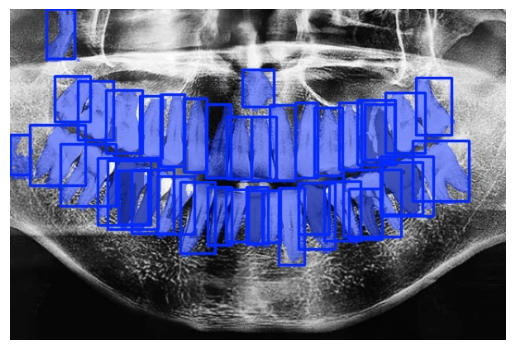

In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import sys

sys.path.append('..')  # Add parent directory to path
from src.preprocessing import enhance_image_from_user

# Function to get the latest 'best.pt' model
def get_latest_model(model_dir):
    """
    Get the path to the latest 'best.pt' model in the specified directory.
    
    Parameters:
    -----------
    model_dir : str
        Directory where the YOLO models are stored.
        
    Returns:
    --------
    str
        Path to the latest 'best.pt' model.
    """
    # List all directories in the given path
    runs_dirs = [d for d in os.listdir(model_dir) if os.path.isdir(os.path.join(model_dir, d))]
    
    # Find the latest run folder by looking at the timestamp
    latest_run = max(runs_dirs, key=lambda d: os.path.getmtime(os.path.join(model_dir, d)))
    
    # Define the path to the best.pt model in the latest run
    model_path = os.path.join(model_dir, latest_run, 'weights', 'best.pt')
    
    return model_path

# Step 1: Enhance the image
input_image_path = '../trial2.jpg'  # Replace with your input image path
output_dir = '../trial test results'  # Replace with your desired output directory

# Enhance the image - you can also customize rho and k parameters here
enhance_image_from_user(input_image_path, output_dir, rho=0.5, k=1.5)

# Get the path to the enhanced image
enhanced_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

# Step 2: Get the latest model path
model_dir = "C:/Users/pauli/DeepDent/periodontitis/notebooks/runs/segment"  # Your base model directory
latest_model_path = get_latest_model(model_dir)

# Load the YOLOv8 segmentation model
model = YOLO(latest_model_path)

# Run inference on the enhanced image
results = model(enhanced_image_path)

# Display the image with segmentation results 
for result in results:
    
    result.show(labels=False, conf=False)  # No labels, no confidence scores
    
    # Optionally, save the output without bounding boxes and labels
    result.save(filename="output2.jpg", labels=False, conf=False)

# Optionally, load and display the saved image using OpenCV
output_image = cv2.imread("output2.jpg")
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()